# Provasi Matteo (782922)

# Assignment 3

## Consegna

<font size=3>

Implementare uno script di classificazione basato sull'estrazione di feature neurali, a partire dalle istruzioni viste ad esercitazione. Non addestrare e testare una rete neurale, ma limitarsi all'uso delle features, con un classificatore esterno. Non è consentito l'uso dello stesso modello visto in laboratorio (ResNet).

Selezionare due diversi problemi di classificazione:

1. Cani VS gatti (lo stesso dell'esercitazione 4, in modo da evidenziare il miglioramento in performance).
2. Problema a scelta (cercare e scaricare un dataset, eventualmente limitandolo in cardinalità).

In [63]:
import keras
import joblib
import numpy as np
import os
import sklearn

from keras.preprocessing import image as kimage
from keras.applications import inception_v3
from keras.applications.inception_v3 import preprocess_input
from matplotlib import pyplot as plt
from skimage import feature

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from time import time

In [2]:
base_path = "C:/path/"

<font size=3>
    
Per questo problema classificativo viene scelto InceptionV3, una Convolutional Neural Network svilppata da Google. Nell'immagine che segue è rappresentata la sua architettura.
![Architettura InceptionV3](https://miro.medium.com/max/1050/1*gqKM5V-uo2sMFFPDS84yJw.png)
<br></br>

Il nome <i>V3</i> indica che è la terza versione di questo modello, in particolare i miglioramenti che sono stati apportati rispetto alle versioni precedenti riguardano la fattorizzazione delle convoluzioni: in questo modello si applicano più convoluzioni però di dimensione inferiore, in questo modo gli autori sono riusciti a diminuire il numero di parametri ma a mantenere delle buone performance classificative. Gli elementi che compongono la rete sono:
* <b>Convolutional Layer</b>: l'obiettivo di questi layer è quello di estrarre delle features di interesse dalla griglia data in input facendo scorrere una finestra la cui dimensione può variare.
* <b>Pooling</b>: sono altri layer per poter estrarre delle features. Sono strumenti di riduzione della dimensionaliltà, restituiscono una griglia con features invarianti per rotazione e posizione. Esistono due tipologie di pooling: 
    1. <b>Maximum</b>: viene preso il valore massimo della finestra considerata.
    2. <b>Average</b>: viene preso il valore medio della finestra considerata.
<br></br>
<br></br>
* <b>Concat</b>: layer di concatenazione che uniscono i valori in input.
* <b>Droput</b>: layer che disattiva in maniera randomica dei neuroni all'interno della rete; la ragione principale di questa scelta è per evitare overfitting durante il training.
* <b>Fully Connected Layer</b>: posti alla fine della rete prendono in input il risultato degli step precedente e restituisce un vettore di lunghezza pari alla numerosità del target.
* <b>Softmax</b>: questa funzione di attivazione prende in input il vettore $n$-dimensioale e modella le probabilità in modo tale che la somma del vettore sia unitaria.

In [64]:
nn = inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling='max')

96116736/96112376 [==============================] - 41s 0us/step


<font size=3>

La rete neurale scelta è <b>InceptionV3</b>, vengono lasciati i parametri di default con <i>include_top=True</i> che permette l'utilizzo di layer fully-connected e un <i>pooling</i> massimo. <br></br>
La seguente funzione per caricare i dati è la stessa dell'assignment precedente, con l'unica differenza che si deve ridimensionare l'immagine in input da passare alla rete neurale. Per costruzione della rete l'immagine deve avere dimensione $299x299$.

In [21]:
def load_data(feature_extractor, maximages=100):
    labels = []
    features = []
    
    for di, d in enumerate(sorted(os.listdir(base_path))):
        for fi, f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            
            if f.endswith('.jpg') and fi < maximages:
                image = kimage.load_img(base_path + d + '/' + f, target_size=(299, 299))
                cur_features = feature_extractor(image)
                features.append(cur_features)
                labels.append(di)
                
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=0)
    return X_train, X_test, y_train, y_test

<font size=3>

Dato che le reti neurali di Keras lavorano con batch di immagini è necessario aggiungere una dimensione attraverso <b>np.expand_dims</b>. La funzione <b>preprocess_input</b> serve per adattare la rete neruale alle immagini che saranno caricate dato che è già pre-addestrata.

In [66]:
def nn_inception(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_v3.preprocess_input(x)
    f = nn.predict(x)
    return f.flatten()

In [68]:
t0 = time()
X_train, X_test, y_train, y_test = load_data(feature_extractor=nn_inception, maximages=500)
print("Caricamento in %0.3f secondi" %(time() - t0))

Caricamento in 563.796 secondi


<font size=3>
    
Come nel precedente assignment viene fatta una normalizzazione e successivamente una grid search per trovare la combinazione ottimale di parametri per la SVC.

In [69]:
X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

In [71]:
param_grid = {'C': [0.5, 1, 1.5, 2],
              'gamma': [0.00001, 0.0001, 0.001, 0.01]} 

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=1)

t1 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t1))

print("Migliore combinazione di parametri:")
print(" C: "+ str(clf.best_estimator_.C))
print(" gamma: "+ str(clf.best_estimator_.gamma))

Addestramento completato in 126.031s
Migliore combinazione di parametri:
 C: 1
 gamma: 1e-05


<font size=3>

La classificazione è quasi ottimale con un'accuratezza del $98$%.

In [72]:
y_pred = clf.predict(X_test)

print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Report di classificazione:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       144
           1       0.98      0.99      0.98       156

   micro avg       0.98      0.98      0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



<font size=3>
    
Osservando la matrice di classificazione si nota come $3$ gatti sono classificati come cani e $2$ cani sono classificati come gatti, tutte le restanti immagini sono identificate correttamente.

Matrice di confusione:
[[141   3]
 [  2 154]]


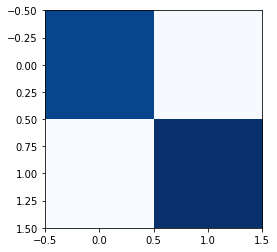

In [73]:
# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

## Problema a scelta

<font size=3>

Per un secondo task di classificazione si è scelto di applicare il classificatore ad un dataset chiamato <i>Natural Images</i> disponibile su [Kaggle](https://www.kaggle.com/prasunroy/natural-images). Il dataset è composto da quasi $7000$ immagini raccolte da diverse fonti, le categorie sono $8$:
* Airplanes
* Cats
* Cars
* Dogs
* Flowers
* Fruits
* Motorbikes
* Persons
<br></br>

La numerosità delle classi varia da un minimo di $700$ fino ad un massimo di $1000$. Viene impostata una nuova directory e si seleziona un nuovo upper bound di <i>maximages</i> per caricare tutte le immagini disponibili. <br></br>
Seguono gli stessi step eseguiti in precedenza, con la normalizzazione e la grid search dei parametri migliori.

In [74]:
base_path = "C:/path/"

In [75]:
t2 = time()
X2_train, X2_test, y2_train, y2_test = load_data(feature_extractor=nn_inception, maximages=1000)
print("Caricamento in %0.3f secondi" %(time() - t2))

Caricamento in 3680.913 secondi


In [76]:
X2_train_stack = np.array([])
for t in X2_train:
    X2_train_stack = np.concatenate((X2_train_stack, t))
eps = 0.001
X2_train_mean = X2_train_stack.mean()
X2_train_std = X2_train_stack.std()
X2_train = [(t - X2_train_mean + eps)/(X2_train_std + eps) for t in X2_train]
X2_test = [(t - X2_train_mean + eps)/(X2_train_std + eps) for t in X2_test]

In [77]:
param_grid = {'C': [0.5, 1, 1.5, 2],
              'gamma': [1e-05, 0.0001, 0.001, 0.01]} 

clf2 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=1)

t3 = time()
clf2 = clf2.fit(X2_train, y2_train)
print("Addestramento completato in %0.3fs" % (time() - t3))

print("Migliore combinazione di parametri:")
print(" C: " + str(clf2.best_estimator_.C))
print(" gamma: " + str(clf2.best_estimator_.gamma))

Addestramento completato in 3961.850s
Migliore combinazione di parametri:
 C: 1.5
 gamma: 0.001


<font size=3>

Il modello riesce a classificare con un'elevatissima accuratezza ($0.9966$) le diverse immagini nelle classi. In questo caso, dato che si hanno più classi, viene creata una lista con le labels che saranno visualizzate nel report di classificazione. <br></br>
Solamente la classe dei cani non ha un'accuracy perfetta che però si attesta comunque al $0.98$.

In [79]:
target_names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

y2_pred = clf2.predict(X2_test)

print("Report di classificazione:")
print(classification_report(y2_test, y2_pred, target_names=target_names))

Report di classificazione:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       222
         car       1.00      1.00      1.00       274
         cat       1.00      0.99      0.99       273
         dog       0.98      1.00      0.99       209
      flower       1.00      0.99      1.00       275
       fruit       1.00      1.00      1.00       299
   motorbike       1.00      1.00      1.00       227
      person       1.00      1.00      1.00       291

   micro avg       1.00      1.00      1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



<font size=3>
    
Dalla matrice si classificazione si può notare come c'è sempre una sola immagine classificata erroneamente per ogni classe, tranne per cani e gatti dove ce ne sono $2$

Matrice di confusione:
[[221   0   0   1   0   0   0   0]
 [  0 274   0   0   0   0   0   0]
 [  0   0 271   2   0   0   0   0]
 [  0   0   1 208   0   0   0   0]
 [  0   0   0   1 273   1   0   0]
 [  0   0   0   0   0 299   0   0]
 [  0   0   0   0   0   0 227   0]
 [  0   0   0   1   0   0   0 290]]


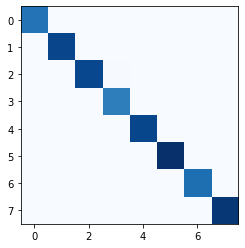

In [80]:
# Matrice di confusione
print("Matrice di confusione:")
cm2 = confusion_matrix(y2_test, y2_pred)
print(cm2)
plt.imshow(cm2, cmap=plt.cm.Blues)